# 3D parameter estimation using MCMC

Leverages the data produced in `drifter_3D.ipynb`

In [1]:
import os 

import xarray as xr
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt

from gptide import cov
from gptide import GPtideScipy
from gptide import stats as gpstats
from gptide import mcmc
import corner
import arviz as az

data_dir = "data/"
data_dir = "/home1/scratch/aponte/"

## Define kernels

In [2]:
case = "matern2_iso_matern12_pp_a0.0"

In [3]:
# load drifters data
dsd = xr.open_dataset(os.path.join(data_dir, f"3D_{case}_parcels_selection.nc"))
dsd_full = xr.open_dataset(os.path.join(data_dir, f"3D_{case}_parcels.nc"))

# load eulerian flow
dsf = xr.open_dataset(os.path.join(data_dir, f"3D_{case}_flow_selection.nc")).sortby("trajectory")
dsf["time"] = dsf["time"]/pd.Timedelta("1D")
dsf_full = xr.open_dataset(os.path.join(data_dir, f"3D_{case}_flow.zarr"))
dsf_full = dsf_full.sel(x=dsf.x, y=dsf.y).compute()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [4]:
# problem parameters (need to be consistent with data generation notebook)

p = dsd.attrs
η = p["eta"]
λx = p["lambda_x"]   # km
λy = p["lambda_y"]   # km
λt = p["lambda_t"]   # days

Lx = float(dsf_full.x.max()-dsf_full.x.min())
Ly = float(dsf_full.y.max()-dsf_full.y.min())
# km, km this should not matter

In [50]:
#from scipy.special import kv, kvp
#from scipy.special import gamma

from numba import njit
from numba import vectorize
import scipy.special as sp

# https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function

@vectorize
def kv(x):
    return sp.kv(1., x)

@njit
def kv1(nu, z):
    """ first derivative """
    #return -1/2*(sp.kv(nu-1., z) + sp.kv(nu+1., z))
    return -1/2*(kv(nu-1., z) + kv(nu+1., z))

@njit
def kv2(nu, z):
    """ second derivative """
    #return 1/4*(sp.kv(nu-2., z) + 2*sp.kv(nu, z) + sp.kv(nu+2., z))
    return 1/4*(kv(nu-2., z) + 2*kv(nu, z) + kv(nu+2., z))

# copy from https://github.com/TIDE-ITRH/gptide/blob/main/gptide/cov.py
@njit
def matern_general(dx, eta, nu, l):
    """General Matern base function"""
    
    cff1 = np.sqrt(2*nu)*np.abs(dx)/l
    K = np.power(eta, 2.) * np.power(2., 1-nu) / sp.gamma(nu)
    K *= np.power(cff1, nu)
    #K *= sp.kv(nu, cff1)
    K *= kv(nu, cff1)
    
    K[np.isnan(K)] = np.power(eta, 2.)
    
    return K

# new
@njit
def matern_general_d1(dx, eta, nu, l):
    """General Matern base function, first derivative"""
    
    cff0 = np.sqrt(2*nu)/l
    cff1 = cff0*np.abs(dx)
    K = np.power(eta, 2.) * np.power(2., 1-nu) / sp.gamma(nu) * cff0
    K *= (
        #nu*np.power(cff1, nu-1)*sp.kv(nu,cff1) 
        nu*np.power(cff1, nu-1)*kv(nu, cff1)
        + np.power(cff1, nu)*kv1(nu, cff1)
    )
    K[np.isnan(K)] = 0.
    # but remember K'(d)/d converge toward K''(0) towards 0
    
    return K

@njit
def matern_general_d2(dx, eta, nu, l):
    """General Matern base function, second derivative"""
    
    cff0 = np.sqrt(2*nu)/l
    cff1 = cff0*np.abs(dx)
    K = np.power(eta, 2.) * np.power(2., 1-nu) / sp.gamma(nu) * cff0**2
    K *= (
        #nu*(nu-1)*np.power(cff1, nu-2)*sp.kv(nu,cff1) 
        nu*(nu-1)*np.power(cff1, nu-2)*kv(nu,cff1) 
        + 2*nu*np.power(cff1, nu-1)*kv1(nu,cff1) 
        + np.power(cff1, nu)*kv2(nu, cff1)
    )
    K[np.isnan(K)] = -np.power(eta, 2.) * nu/(nu-1)/l**2
    
    return K

In [51]:
uv = True # True if u and v are observed

isotropy = False

if p["cov_x"] == "matern12_xy":
    Cx = cov.matern12  # -2 spectral slope
    Cy = cov.matern12  # -2 spectral slope
elif p["cov_x"] == "matern32_xy":
    Cx = cov.matern32  # -4 spectral slope: not twice differentiable
    Cy = cov.matern32  # -4 spectral slope: 
elif p["cov_x"] == "matern2_xy":
    #Cov_x = cov.matern_general(np.abs(t_x - t_x.T), 1., 2, λx) # -5 spectral slope
    #Cov_y = cov.matern_general(np.abs(t_y - t_y.T), 1., 2, λy) # -5 spectral slope
    pass
elif p["cov_x"] == "matern52_xy":
    Cx = cov.matern52  # -6 spectral slope
    Cy = cov.matern52  # -6 spectral slope
elif p["cov_x"] == "expquad":
    #jitter = -10
    Cx = cov.expquad(t_x, t_x.T, λx) # + 1e-10 * np.eye(Nx)
    Cy = cov.expquad(t_y, t_y.T, λy) # + 1e-10 * np.eye(Nx)

if p["cov_x"] == "matern2_iso":
    # for covariances based on distances
    @njit
    def Cu(x, y, d, λ):
        C = -(
            y**2 * matern_general_d2(d, 1., 2., λ)
            + x**2 * matern_general_d1(d, 1., 2., λ) / d
        )/ d**2
        C[np.isnan(C)] = -2*matern_general_d2(d[np.isnan(C)], 1.0, 2., λ)
        #C[np.isnan(C)] = 1 + d[np.isnan(C)]*0.
        return C
    @njit
    def Cv(x, y, d, λ):
        C = -(
            x**2 * matern_general_d2(d, 1., 2., λ)
            + y**2 * matern_general_d1(d, 1., 2., λ) / d
        ) / d**2
        C[np.isnan(C)] = -2*matern_general_d2(d[np.isnan(C)], 1.0, 2., λ)
        return C
    @njit
    def Cuv(x, y, d, λ):
        C = x*y*(
                matern_general_d2(d, 1., 2., λ)
                - matern_general_d1(d, 1., 2., λ) / d
            ) / d**2
        C[np.isnan(C)] = 0.
        return C
        

    isotropy = True

Ct = getattr(cov, p["cov_t"])

In [42]:
# new
@njit
def matern_general_d1(dx, eta, nu, l):
    """General Matern base function, first derivative"""
    
    cff0 = np.sqrt(2*nu)/l
    cff1 = cff0*np.abs(dx)
    K = np.power(eta, 2.) * np.power(2., 1-nu) / sp.gamma(nu) * cff0
    K *= (
        nu*np.power(cff1, nu-1)*sp.kv(nu, cff1) 
        + np.power(cff1, nu)*kv1(nu, cff1)
    )
    return K

In [52]:
matern_general_d1(t_x2, 1., 2., 1.)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function imul>) found for signature:
 
 >>> imul(float64, array(float64, 2d, C))
 
There are 10 candidate implementations:
[1m  - Of which 8 did not match due to:
  Overload of function 'imul': File: <numerous>: Line N/A.
    With argument(s): '(float64, array(float64, 2d, C))':[0m
[1m   No match.[0m
[1m  - Of which 2 did not match due to:
  Operator Overload in function 'imul': File: unknown: Line unknown.
    With argument(s): '(float64, array(float64, 2d, C))':[0m
[1m   No match for registered cases:
    * (int64, int64) -> int64
    * (int64, uint64) -> int64
    * (uint64, int64) -> int64
    * (uint64, uint64) -> uint64
    * (float32, float32) -> float32
    * (float64, float64) -> float64
    * (complex64, complex64) -> complex64
    * (complex128, complex128) -> complex128[0m
[0m
[0m[1mDuring: typing of intrinsic-call at /dev/shm/pbs.6332997.datarmor0/ipykernel_26089/1497309625.py (49)[0m
[1m
File "../../../../../dev/shm/pbs.6332997.datarmor0/ipykernel_26089/1497309625.py", line 49:[0m
[1m<source missing, REPL/exec in use?>[0m


In [37]:
t_x2

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  2.,   2.,   2., ...,   2.,   2.,   2.],
       [  4.,   4.,   4., ...,   4.,   4.,   4.],
       ...,
       [194., 194., 194., ..., 194., 194., 194.],
       [196., 196., 196., ..., 196., 196., 196.],
       [198., 198., 198., ..., 198., 198., 198.]])

In [40]:
matern_general_d1(1., 1., 2., 1.)

1.0

In [19]:
Cu(1., 2., 1., 10)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
Internal error at resolving type of attribute "kv1" of "$142load_global.67".
[1m[1mmodule 'scipy.special' has no attribute 'kv1'[0m
[0m[1mDuring: typing of get attribute at /dev/shm/pbs.6332997.datarmor0/ipykernel_26089/849325984.py (59)[0m
Enable logging at debug level for details.
[1m
File "../../../../../dev/shm/pbs.6332997.datarmor0/ipykernel_26089/849325984.py", line 59:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function matern_general_d2 at 0x2aaae823da60>))[0m
[0m[1mDuring: typing of call at /dev/shm/pbs.6332997.datarmor0/ipykernel_26089/2287309421.py (28)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function matern_general_d2 at 0x2aaae823da60>))[0m
[0m[1mDuring: typing of call at /dev/shm/pbs.6332997.datarmor0/ipykernel_26089/2287309421.py (28)
[0m
[1m
File "../../../../../dev/shm/pbs.6332997.datarmor0/ipykernel_26089/2287309421.py", line 28:[0m
[1m<source missing, REPL/exec in use?>[0m


In [18]:
### inspect covariance

Nx, dx = 100, 2.  # km
Ny, dy = 100, 2.  # km
#Nt, dt = 100*24, 1/24  # days

t_x = np.arange(Nx)[:, None]*dx
t_y = np.arange(Ny)[:, None]*dy
#t_t = np.arange(Nt)[:, None]*dt

t_x2 = t_x   + t_y.T*0
t_y2 = t_x*0 + t_y.T  
t_d2 = np.sqrt(t_x2**2+t_y2**2)

Cov = xr.Dataset(
    dict(
        u=(("x", "y"), Cu(t_x2, t_y2, t_d2, λx)),
        v=(("x", "y"), Cv(t_x2, t_y2, t_d2, λx)),
        uv=(("x", "y"), Cuv(t_x2, t_y2, t_d2, λx)),
    ), 
                 
    coords=dict(x=("x", t_x[:,0]), y=("y", t_y[:,0]),),
)

cmax = max(
    float(np.abs(Cov.u).max()), 
    float(np.abs(Cov.v).max())
)
kwargs = dict(
    x="x", levels=20, vmax=cmax, vmin=-cmax, cmap="RdBu_r", add_colorbar=False,
)

fig, axes = plt.subplots(1,3, figsize=(10,5), sharey=True)
ax = axes[0]
Cov.u.plot.contourf(ax=ax, **kwargs)
ax.set_aspect("equal")
ax.set_title("u covariance")

ax = axes[1]
Cov.v.plot.contourf(ax=ax, **kwargs)
ax.set_aspect("equal")
ax.set_ylabel("")
ax.set_title("v covariance")

ax = axes[2]
Cov.uv.plot.contourf(ax=ax, **kwargs)
ax.set_aspect("equal")
ax.set_ylabel("")
ax.set_title("uv covariance")

#ax.set_title("u Covariance")


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1m[1m[1m[1m[1m[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<ufunc 'kv'>) found for signature:
 
 >>> kv(float64, array(float64, 2d, C))
 
There are 2 candidate implementations:
[1m      - Of which 2 did not match due to:
      Overload of function 'kv': File: numba_scipy/special/overloads.py: Line 9.
        With argument(s): '(float64, array(float64, 2d, C))':[0m
[1m       No match.[0m
[0m
[0m[1mDuring: resolving callee type: Function(<ufunc 'kv'>)[0m
[0m[1mDuring: typing of call at /dev/shm/pbs.6332997.datarmor0/ipykernel_26089/849325984.py (58)
[0m
[1m
File "../../../../../dev/shm/pbs.6332997.datarmor0/ipykernel_26089/849325984.py", line 58:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function matern_general_d2 at 0x2aaae823da60>))[0m
[0m[1mDuring: typing of call at /dev/shm/pbs.6332997.datarmor0/ipykernel_26089/1405456696.py (28)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function matern_general_d2 at 0x2aaae823da60>))[0m
[0m[1mDuring: typing of call at /dev/shm/pbs.6332997.datarmor0/ipykernel_26089/1405456696.py (28)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function matern_general_d2 at 0x2aaae823da60>))[0m
[0m[1mDuring: typing of call at /dev/shm/pbs.6332997.datarmor0/ipykernel_26089/2287309421.py (28)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function matern_general_d2 at 0x2aaae823da60>))[0m
[0m[1mDuring: typing of call at /dev/shm/pbs.6332997.datarmor0/ipykernel_26089/2287309421.py (28)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function matern_general_d2 at 0x2aaae823da60>))[0m
[0m[1mDuring: typing of call at /dev/shm/pbs.6332997.datarmor0/ipykernel_26089/2287309421.py (28)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function matern_general_d2 at 0x2aaae823da60>))[0m
[0m[1mDuring: typing of call at /dev/shm/pbs.6332997.datarmor0/ipykernel_26089/2287309421.py (28)
[0m
[1m
File "../../../../../dev/shm/pbs.6332997.datarmor0/ipykernel_26089/2287309421.py", line 28:[0m
[1m<source missing, REPL/exec in use?>[0m


In [15]:
def kernel_3d(x, xpr, params):
    """
    3D kernel
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 4
            eta: standard deviation
            lx: x length scale
            ly: y length scale
            lt: t length scale
            
    """
    eta, lx, ly, lt = params
    
    # Build the covariance matrix
    C  = Ct(x[:,2,None], xpr.T[:,2,None].T, lt)
    C *= Cy(x[:,1,None], xpr.T[:,1,None].T, ly) 
    C *= Cx(x[:,0,None], xpr.T[:,0,None].T, lx)
    C *= eta**2
    
    return C

def kernel_3d_iso(x, xpr, params):
    """
    3D kernel
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 4
            eta: standard deviation
            ld: spatial scale
            lt: t length scale
            
    """
    eta, ld, lt = params
    
    # Build the covariance matrix
    C  = Ct(x[:,2,None], xpr.T[:,2,None].T, lt)
    d = np.sqrt( (x[:,0,None]  - xpr.T[:,0,None].T)**2 + (x[:,1,None]  - xpr.T[:,1,None].T)**2 )
    C *= Cx(d, ld)
    C *= eta**2
    
    return C

def kernel_3d_iso_uv(x, xpr, params):
    """
    3D kernel, one velocity component
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 4
            eta: standard deviation
            ld: spatial scale
            lt: t length scale
            
    """
    eta, ld, lt = params
    
    # Build the covariance matrix
    _Ct  = Ct(x[:,2,None], xpr.T[:,2,None].T, lt)
    n = x.shape[0]//2
    _x = x[:n,0,None] - xpr.T[:n,0,None].T
    _y = x[:n,1,None] - xpr.T[:n,1,None].T
    _d = np.sqrt( _x**2 + _y**2 )
    _Cu  = Cu(_x, _y, _d, ld)
    _Cv  = Cv(_x, _y, _d, ld)
    _Cuv  = Cuv(_x, _y, _d, ld)
    C = _Ct*np.block([[_Cu, _Cuv],[_Cuv, _Cv]])
    C *= eta**2
    
    return C

def kernel_3d_iso_u(x, xpr, params):
    """
    3D kernel, one velocity component
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 4
            eta: standard deviation
            ld: spatial scale
            lt: t length scale
            
    """
    eta, ld, lt = params
    
    # Build the covariance matrix
    C  = Ct(x[:,2,None], xpr.T[:,2,None].T, lt)
    _x = x[:,0,None] - xpr.T[:,0,None].T
    _y = x[:,1,None] - xpr.T[:,1,None].T
    _d = np.sqrt( _x**2 + _y**2 )
    C  *= Cu(_x, _y, _d, ld)
    C *= eta**2
    
    return C

def kernel_1d(x, xpr, params):
    """
    1D kernel - temporal
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 4
            eta: standard deviation
            lx: x length scale
            ly: y length scale
            lt: t length scale
            
    """
    eta, lt = params
    
    # Build the covariance matrix
    C  = Ct(x[:,2,None], xpr.T[:,2,None].T, lt)
    C *= eta**2
    
    return C

In [16]:
# Initial guess of the noise and covariance parameters (these can matter)
noise = 0.01
η = .2

if isotropy:
    if uv:
        covfunc = kernel_3d_iso_uv
    else:
        covfunc = kernel_3d_iso_u
    covparams = [η, λx, λt]
    noise_prior      = gpstats.truncnorm(noise, noise*2, noise/10, noise*10)     # noise
    covparams_priors = [gpstats.truncnorm(η, η*2, η/10, η*10),                   # eta
                        gpstats.truncnorm(λx, λx*2, λx/10, λx*10),               # λx
                        gpstats.truncnorm(λt, λt*2, λt/10, λt*10),               # λt
                       ]
else:
    covfunc = kernel_3d
    covparams = [η, λx, λy, λt]
    noise_prior      = gpstats.truncnorm(noise, noise*2, noise/10, noise*10)     # noise
    covparams_priors = [gpstats.truncnorm(η, η*2, η/10, η*10),                   # eta
                        gpstats.truncnorm(λx, λx*2, λx/10, λx*10),               # λx
                        gpstats.truncnorm(λy, λy*2, λy/10, λy*10),               # λy
                        gpstats.truncnorm(λt, λt*2, λt/10, λt*10),               # λt
                       ]

---

## Inference: fixed points -  space/time

We now use the `gptide.mcmc` function do the parameter estimation. This uses the `emcee.EnsembleSampler` class.


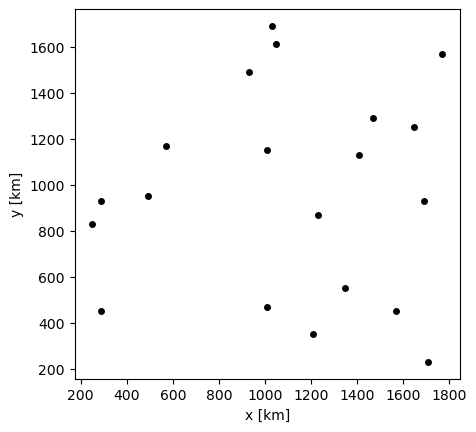

In [48]:
fig, ax = plt.subplots(1,1)
dsf.plot.scatter(x="x",y="y", c="k", ax=ax)
ax.set_aspect("equal")

In [49]:
# load data
ds = dsf

dt0 = float(np.unique(ds.time.diff("time"))[0])
print(f"initial time sampling rate {dt0} days")

ds

initial time sampling rate 0.041666665999997576 days


<xarray.Dataset>
Dimensions:  (time: 2400, trajectory: 20)
Coordinates:
  * time     (time) float64 -0.02083 0.02083 0.0625 0.1042 ... 99.85 99.9 99.94
    x        (trajectory) float64 1.69e+03 290.0 1.35e+03 ... 1.23e+03 1.57e+03
    y        (trajectory) float64 930.0 450.0 550.0 230.0 ... 930.0 870.0 450.0
Dimensions without coordinates: trajectory
Data variables:
    u        (time, trajectory) float64 ...
    v        (time, trajectory) float64 ...
    phi      (time, trajectory) float64 ...
    psi      (time, trajectory) float64 ...
Attributes:
    kind:        pp
    eta:         0.2
    lambda_x:    100
    lambda_y:    100
    lambda_t:    5
    cov_x:       matern2_iso
    cov_y:       matern2_iso
    cov_t:       matern12
    amplitude0:  14.142135623730951
    amplitude1:  0.0
    alpha:       0.0
    noise:       0.0

In [50]:
# decimate
#ds = ds.sel(time=slice(0, None, int(2/dt0)))   # temporally
ds = ds.sel(time=slice(0, None, int(20/dt0)))   # temporally
ds = ds.isel(trajectory=slice(0, None, 5))    # spatially

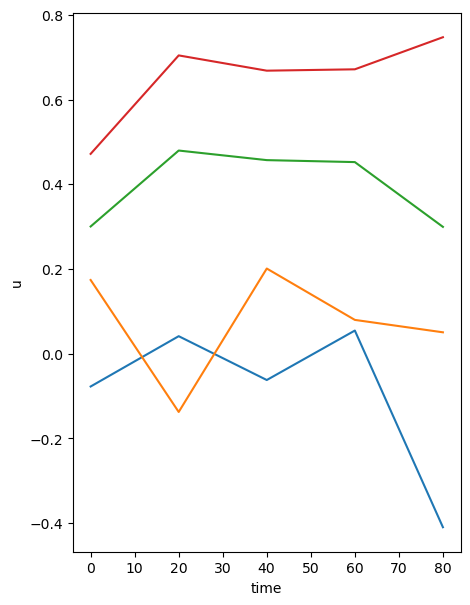

In [51]:
da = ds.u
da  = da + np.arange(ds.trajectory.size)/5
da.plot(hue="trajectory", add_legend=False, figsize=(5,7));

#fig, ax = plt.subplots(1,1)
#ax.scatter(ds.x, ds.y)

In [52]:
# number of data points
N = ds.u.size
Nxy = ds.trajectory.size
print(f"Number of data points = {N}, ({Nxy} spatial locations)")

# problem parameters (need to be consistent with data generation notebook)
Lt = float(ds.time.max()-ds.time.min()) # days

# estimate effective resolution
δx = Lx/Nxy
δy = Ly/Nxy
δt = float(ds.time.diff("time")[0])
print("-- resolutions:")
print(f"λx/δx = {λx/δx}")
print(f"λy/δy = {λy/δy}")
print(f"λt/δt = {λt/δt}")

# estimate number of independent samples
print("-- independent samples (conservative):")
print(f"Lx/λx = {Lx/λx} ") # this is probably conservative
print(f"Ly/λy = {Ly/λy} ") # this is probably conservative
print(f"Lt/λt = {Lt/λt} ") # this is probably conservative

Number of data points = 20, (4 spatial locations)
-- resolutions:
λx/δx = 0.2631578947368421
λy/δy = 0.273972602739726
λt/δt = 0.25
-- independent samples (conservative):
Lx/λx = 15.2 
Ly/λy = 14.6 
Lt/λt = 16.0 


In [53]:
u, v, x, y, t = xr.broadcast(ds.u, ds.v, ds.x, ds.y, ds.time)
assert u.shape==v.shape==x.shape==y.shape==t.shape
x = x.values.ravel()
y = y.values.ravel()
t = t.values.ravel()

X = np.hstack([x[:,None], y[:,None], t[:,None]])
u = ds.u.values.ravel()[:, None]
v = ds.u.values.ravel()[:, None]

# add noise
u += np.random.randn(*u.shape)*noise
v += np.random.randn(*v.shape)*noise

if uv:
    X = np.vstack([X, X])
    U = np.vstack([u, v])
else:
    U = u

print(X.shape, U.shape)

(40, 3) (40, 1)


In [54]:
samples, log_prob, priors_out, sampler = mcmc.mcmc(
    X,
    U,
    covfunc,
    covparams_priors,
    noise_prior,
    nwarmup=100,
    niter=100,
    verbose=False,
)

Running burn-in...


/dev/shm/pbs.6329881.datarmor0/ipykernel_30932/4039761195.py:43: RuntimeWarning: invalid value encountered in multiply
  + 2*nu*np.power(cff1, nu-1)*kvp(nu,cff1, n=1)
/dev/shm/pbs.6329881.datarmor0/ipykernel_30932/4039761195.py:44: RuntimeWarning: invalid value encountered in multiply
  + np.power(cff1, nu)*kvp(nu, cff1, n=2)
/dev/shm/pbs.6329881.datarmor0/ipykernel_30932/4039761195.py:27: RuntimeWarning: invalid value encountered in multiply
  nu*np.power(cff1, nu-1)*kv(nu,cff1)
/dev/shm/pbs.6329881.datarmor0/ipykernel_30932/4039761195.py:28: RuntimeWarning: invalid value encountered in multiply
  + np.power(cff1, nu)*kvp(nu, cff1, n=1)
/dev/shm/pbs.6329881.datarmor0/ipykernel_30932/3855420110.py:28: RuntimeWarning: invalid value encountered in divide
  + x**2 * matern_general_d1(d, 1.0, 2, λ) / d
/dev/shm/pbs.6329881.datarmor0/ipykernel_30932/3855420110.py:36: RuntimeWarning: invalid value encountered in divide
  + y**2 * matern_general_d1(d, 1.0, 2, λ) / d
/dev/shm/pbs.6329881.datar

Running production...


100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


### Find sample with highest log prob

In [55]:
i = np.argmax(log_prob)
MAP = samples[i, :]

print('noise (true): {:3.2f},  noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
print('η   (true):   {:3.2f},  η     (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
print('λx (true):   {:3.2f},   λx   (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))
print('λy (true):   {:3.2f},   λy   (mcmc): {:3.2f}'.format(covparams[2],  MAP[3])) 
print('λt (true):   {:3.2f},   λt   (mcmc): {:3.2f}'.format(covparams[3],  MAP[4])) 

noise (true): 0.01,  noise (mcmc): 0.10
η   (true):   0.20,  η     (mcmc): 0.12
λx (true):   100.00,   λx   (mcmc): 193.44
λy (true):   5.00,   λy   (mcmc): 9.17


IndexError: list index out of range

### Posterior density plot

0.01 Axes(0.125,0.11;0.133621x0.77)
0.2 Axes(0.285345,0.11;0.133621x0.77)
100 Axes(0.44569,0.11;0.133621x0.77)
100 Axes(0.606034,0.11;0.133621x0.77)
5.0 Axes(0.766379,0.11;0.133621x0.77)


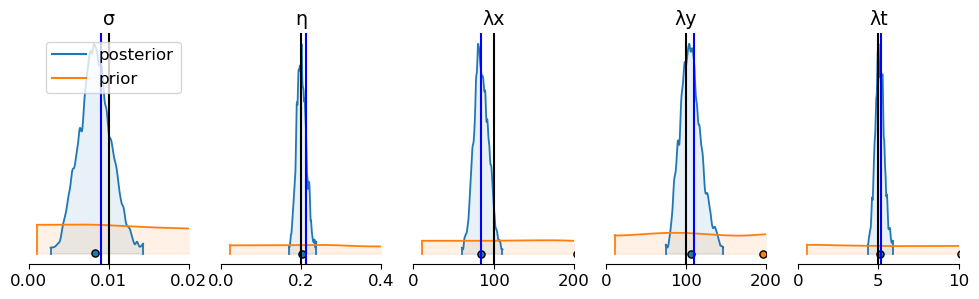

In [19]:
labels = ['σ','η','λx', 'λy', 'λt']
def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples, labels)

axs = az.plot_density(   [samples_az[labels], 
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 5),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)

for t, m, ax in zip([noise,]+list(covparams), MAP, axs[0]):
    print(t, ax)
    ax.axvline(t, color="k", ls="-")
    ax.axvline(m, color="b", ls="-")
    ax.set_xlim(0, t*2)

## Posterior corner plot

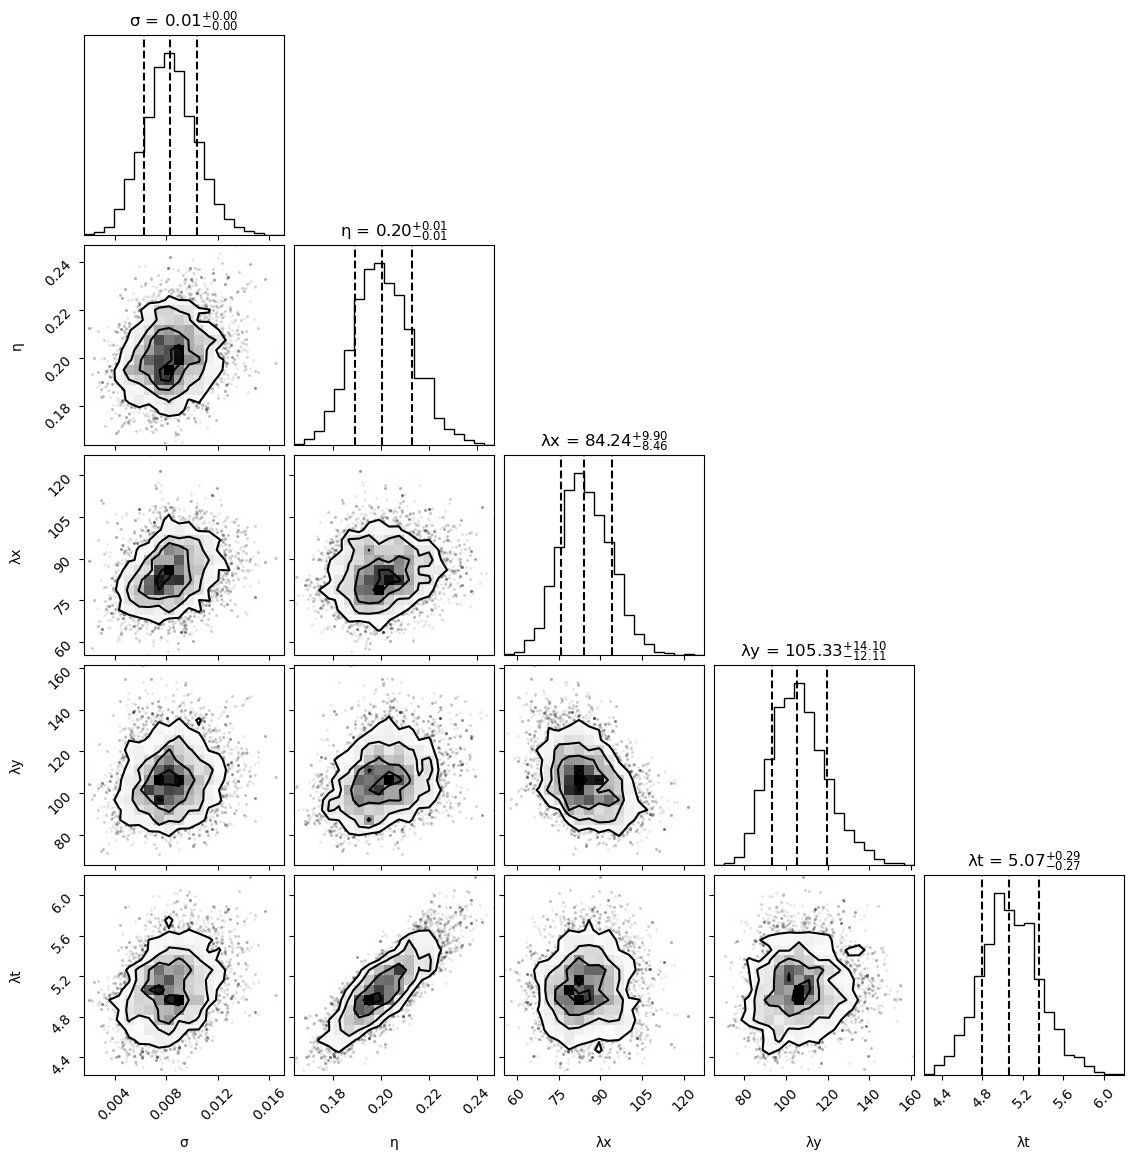

In [20]:
fig = corner.corner(samples, 
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])

---

## Inference: drifters - space/time

In [53]:
# load data
#ds = xr.open_dataset("data/parcels_3D_selection.nc", decode_times=False)
ds = dsd

dt0 = float(np.median(ds.time.diff("time")))
print(f"initial time sampling rate {dt0:.03f} days")

#ds

initial time sampling rate 0.042 days


In [11]:
# decimate
ds = ds.sel(time=slice(0, None, int(2/dt0)))   # temporally
#ds = ds.isel(trajectory=slice(0, None, 1))    # spatially

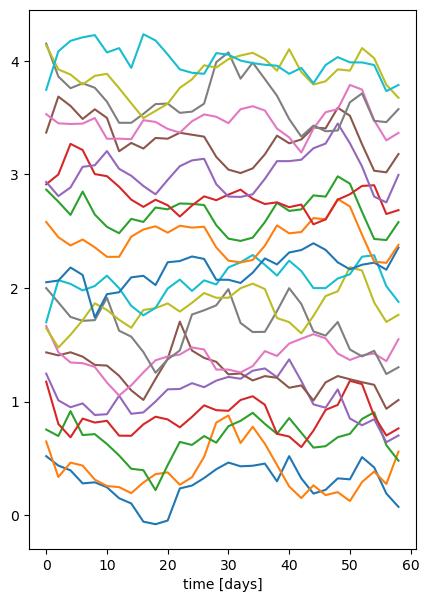

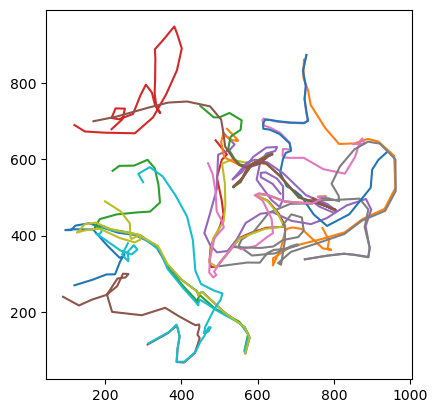

In [12]:
da = ds.u
da  = da + xr.ones_like(ds.trajectory).cumsum("trajectory")/5
da.plot(hue="trajectory", add_legend=False, figsize=(5,7));

fig, ax = plt.subplots(1,1)
#ax.scatter(ds.x, ds.y)
for tr in ds.trajectory:
    _ds = ds.sel(trajectory=tr)
    ax.plot(_ds.x, _ds.y)
#    ds.scatter.plot("x", "y", hue="trajectory", ax=ax)
ax.set_aspect("equal")

In [13]:
# number of data points
N = ds.u.size
Nxy = ds.trajectory.size
print(f"Number of data points = {N}, ({Nxy} drifters)")

# problem parameters (need to be consistent with data generation notebook)
Lt = float(ds.time.max()-ds.time.min()) # days

# estimate effective resolution
δx = Lx/Nxy
δy = Ly/Nxy
δt = float(ds.time.diff("time")[0])
print("-- resolutions:")
print(f"λx/δx = {λx/δx}")
print(f"λy/δy = {λy/δy}")
print(f"λt/δt = {λt/δt}")

# estimate number of independent samples
print("-- independent samples (conservative):")
print(f"Lx/λx = {Lx/λx} ") # this is probably conservative
print(f"Ly/λy = {Ly/λy} ") # this is probably conservative
print(f"Lt/λt = {Lt/λt} ") # this is probably conservative

Number of data points = 600, (20 drifters)
-- resolutions:
λx/δx = 2.0
λy/δy = 2.0
λt/δt = 2.5
-- independent samples (conservative):
Lx/λx = 10.0 
Ly/λy = 10.0 
Lt/λt = 11.6 


In [14]:
# massage inputs to inference problem
u, x, y, t = xr.broadcast(ds.u, ds.x, ds.y, ds.time)
assert u.shape==x.shape==y.shape==t.shape
x = x.values.ravel()
y = y.values.ravel()
t = t.values.ravel()

X = np.hstack([x[:,None], y[:,None], t[:,None]])

u = u.values.ravel()[:, None]
# add noise
#u += noise*np.random.randn(*u.shape)

print(X.shape, u.shape)

(600, 3) (600, 1)


### actually perform inference

In [15]:
#noise_prior      = gpstats.truncnorm(noise, noise*2, noise/10, noise*3)     # noise

In [16]:
samples, log_prob, priors_out, sampler = mcmc.mcmc(X, 
                                                   u, 
                                                    covfunc, 
                                                    covparams_priors,
                                                    noise_prior,
                                                    nwarmup=100,
                                                    niter=100,
                                                    verbose=False,
                                                  )

Running burn-in...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:14<00:00,  6.74s/it]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:19<00:00,  6.79s/it]


In [17]:
i = np.argmax(log_prob)
MAP = samples[i, :]

print('noise (true): {:3.2f},  noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
print('η   (true):   {:3.2f},  η     (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
print('λx (true):   {:3.2f},   λx   (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))
print('λy (true):   {:3.2f},   λy   (mcmc): {:3.2f}'.format(covparams[2],  MAP[3])) 
print('λt (true):   {:3.2f},   λt   (mcmc): {:3.2f}'.format(covparams[3],  MAP[4])) 
#print('λt (true):   {:3.2f},   λt   (mcmc): {:3.2f}'.format(covparams[2],  MAP[3]))

noise (true): 0.01,  noise (mcmc): 0.00
η   (true):   0.20,  η     (mcmc): 0.18
λx (true):   100.00,   λx   (mcmc): 80.92
λy (true):   100.00,   λy   (mcmc): 88.01
λt (true):   5.00,   λt   (mcmc): 4.87


/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


0.01 Axes(0.125,0.11;0.133621x0.77)
0.2 Axes(0.285345,0.11;0.133621x0.77)
100 Axes(0.44569,0.11;0.133621x0.77)
100 Axes(0.606034,0.11;0.133621x0.77)
5.0 Axes(0.766379,0.11;0.133621x0.77)


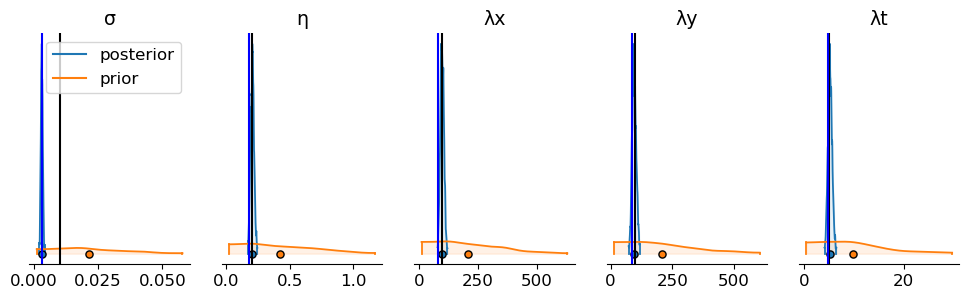

In [18]:
labels = ['σ','η','λx', 'λy', 'λt']
#labels = ['σ','η','λx', 'λt']
def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples, labels)

axs = az.plot_density(   [samples_az[labels], 
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 5),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)

for t, m, ax in zip([noise,]+list(covparams), MAP, axs[0]):
    print(t, ax)
    ax.axvline(t, color="k", ls="-")
    ax.axvline(m, color="b", ls="-")
    #ax.set_xlim(0, t*2)

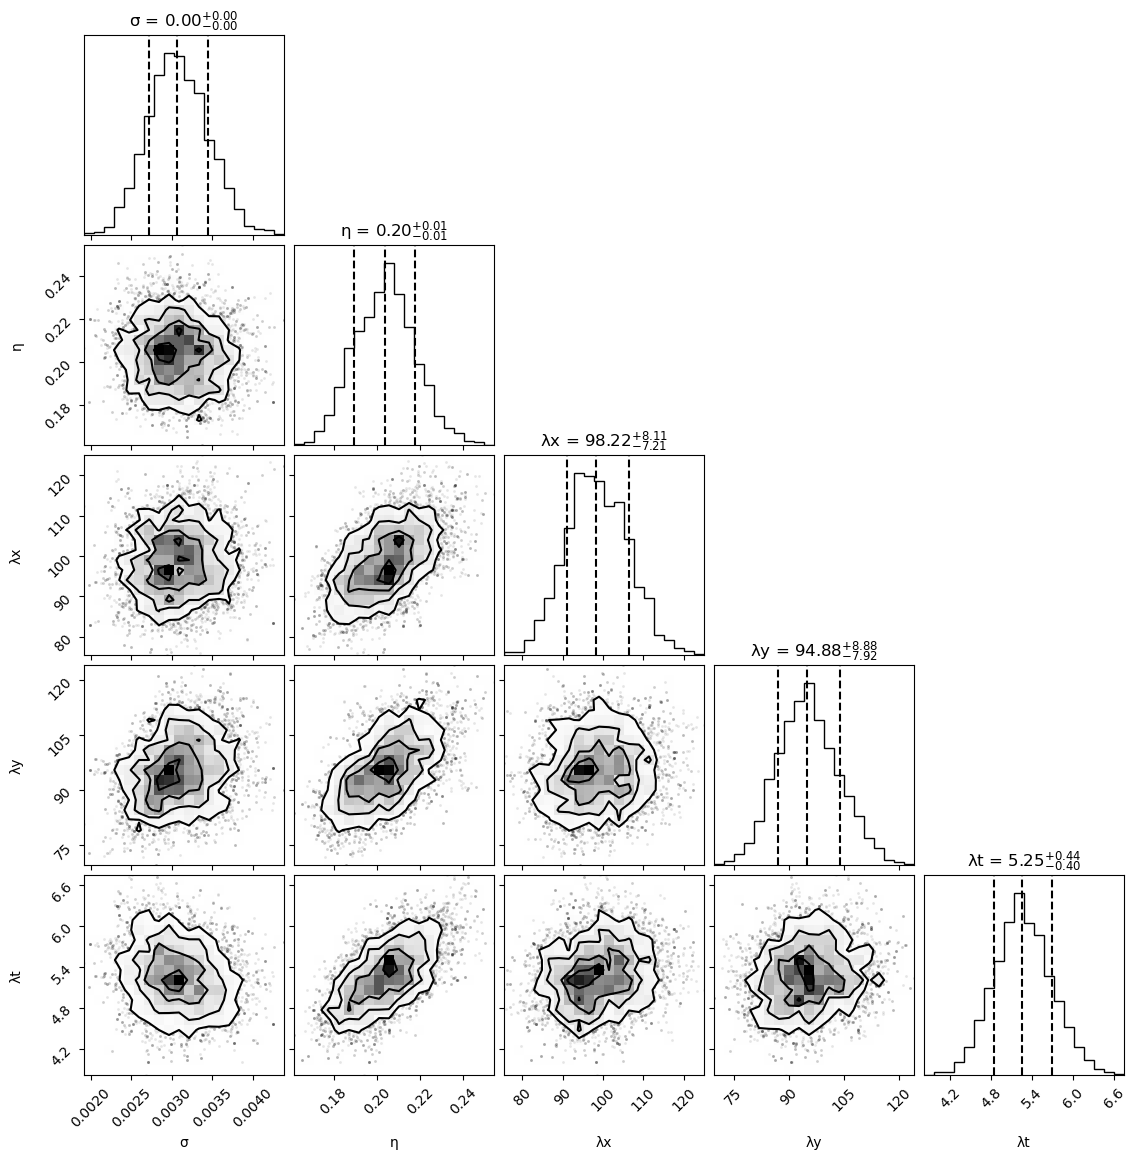

In [19]:
fig = corner.corner(samples, 
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])

In [ ]:
#from crossagg import cx_agg

---

## Inference: drifters - time only

In [65]:
# Initial guess of the noise and covariance parameters (these can matter)
noise = 0.01
η = .2

covfunc = kernel_1d
covparams = [η, λt]
noise_prior      = gpstats.truncnorm(noise, noise*2, noise/10, noise*10)     # noise
covparams_priors = [gpstats.truncnorm(η, η*2, η/10, η*10),                   # eta
                    gpstats.truncnorm(λt, λt*2, λt/10, λt*10),               # λt
                   ]

In [71]:
# load data
ds = dsd

dt0 = float(np.median(ds.time.diff("time")))
print(f"initial time sampling rate {dt0} days")

# decimate
ds = ds.sel(time=slice(0, None, int(2/dt0)))   # temporally
#ds = ds.isel(trajectory=slice(0, None, 1))    # spatially

# select one drifter:
ds = ds.isel(trajectory=0)

ds

initial time sampling rate 0.041666666666666075 days


<xarray.Dataset>
Dimensions:     (time: 30)
Coordinates:
  * time        (time) float64 0.0 2.0 4.0 6.0 8.0 ... 50.0 52.0 54.0 56.0 58.0
    trajectory  int64 739
Data variables:
    y           (time) float32 ...
    x           (time) float32 ...
    u           (time) float64 ...
    v           (time) float64 ...
Attributes: (12/17)
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           flat
    parcels_version:        2.4.2
    eta:                    0.2
    ...                     ...
    cov_t:                  matern12
    kind:                   pp
    amplitude0:             14.142135623730951
    amplitude1:             0.0
    alpha:                  0.0
    noise:                  0.0

In [72]:
# should estimate effective number of points ...

In [73]:
def massage
u, x, y, t = xr.broadcast(ds.u, ds.x, ds.y, ds.time)
assert u.shape==x.shape==y.shape==t.shape
x = x.values.ravel()
y = y.values.ravel()
t = t.values.ravel()

X = np.hstack([x[:,None], y[:,None], t[:,None]])
u = ds.u.values.ravel()[:, None]

# add noise
u += np.random.randn(*u.shape)*noise

print(X.shape, u.shape)

(30, 3) (30, 1)


In [74]:
samples, log_prob, priors_out, sampler = mcmc.mcmc(
    X,
    u,
    covfunc,
    covparams_priors,
    noise_prior,
    nwarmup=100,
    niter=100,
    verbose=False,
)

Running burn-in...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.86it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.46it/s]


In [75]:
i = np.argmax(log_prob)
MAP = samples[i, :]

print('noise (true): {:3.2f},  noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
print('η   (true):   {:3.2f},  η     (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
print('λt (true):   {:3.2f},   λt   (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))

noise (true): 0.01,  noise (mcmc): 0.02
η   (true):   0.20,  η     (mcmc): 0.27
λt (true):   5.00,   λt   (mcmc): 0.78


/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


0.01 Axes(0.125,0.11;0.133621x0.77)
0.2 Axes(0.285345,0.11;0.133621x0.77)
5 Axes(0.44569,0.11;0.133621x0.77)


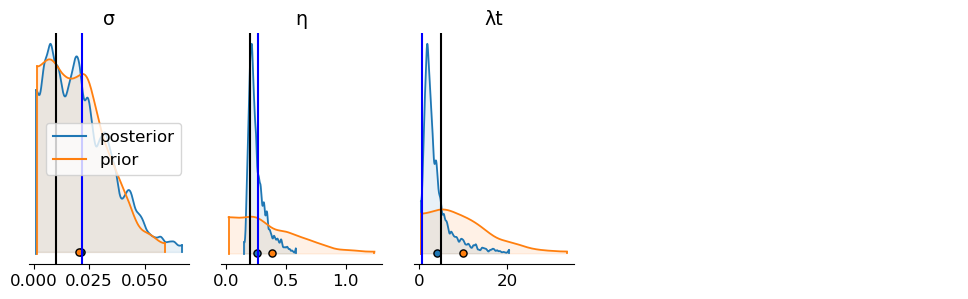

In [76]:
labels = ['σ', 'η', 'λt']
def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples, labels)

axs = az.plot_density(   [samples_az[labels], 
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 5),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)

for t, m, ax in zip([noise,]+list(covparams), MAP, axs[0]):
    print(t, ax)
    ax.axvline(t, color="k", ls="-")
    ax.axvline(m, color="b", ls="-")
    #ax.set_xlim(0, t*2)

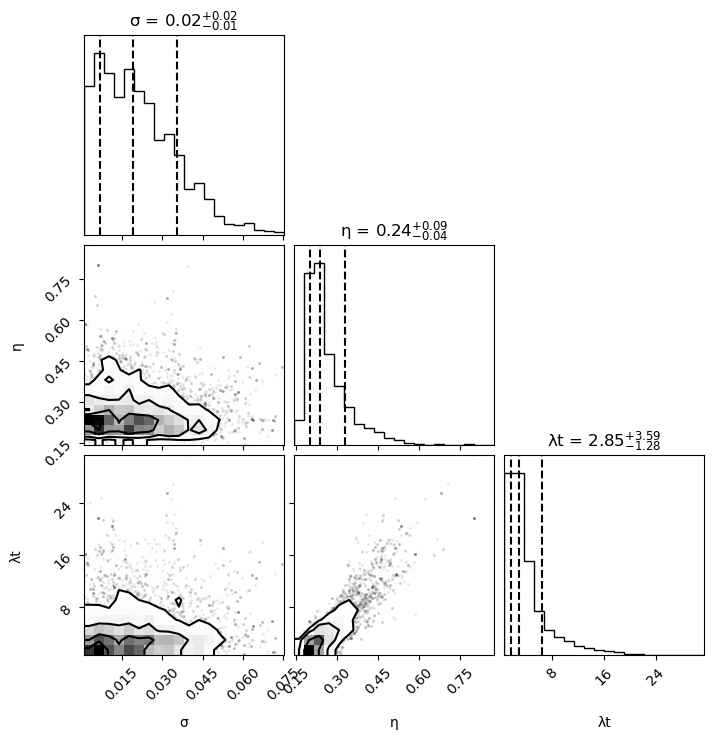

In [77]:
fig = corner.corner(samples, 
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])

### inference fixed-points

In [ ]:
# load data
ds = dsd
dt0 = float(np.median(ds.time.diff("time")))
print(f"initial time sampling rate {dt0} days")
# decimate
ds = ds.sel(time=slice(0, None, int(2/dt0)))   # temporally
#ds = ds.isel(trajectory=slice(0, None, 1))    # spatially
ds

---
### empirical spectra

In [20]:
import pynsitu as pin

In [21]:
Ed = dsd.ts.spectrum(method='periodogram', include=["u", "v"], detrend="linear")
Ef = dsf.ts.spectrum(method='periodogram', include=["u", "v"], detrend="linear")

In [22]:
#eta = float(dsd.u.std())
eta = η
if p["cov_t"]=="matern12":
    nu = 1/2
elif p["cov_t"]=="matern32":
    nu = 3/2
E_input = cov.matern_spectra(Ed.frequency, eta, nu, λt)

In [28]:
# interpolate eulerian field on a finer timeline
dsf_full_interp = dsf_full.resample(time="1H").interpolate()
Ef_interp = dsf_full_interp.ts.spectrum(method='periodogram', include=["U", "V"], detrend="linear", unit="1D")

Text(0.5, 1.0, '')

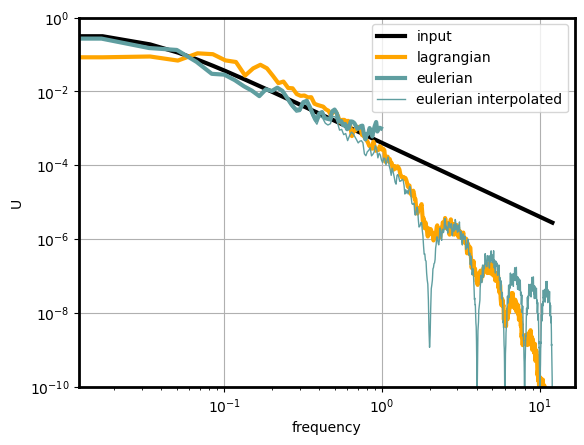

In [33]:
fig, ax = plt.subplots(1,1)
#Ed.u.plot(hue="trajectory", add_legend=False, color="0.5", alpha=0.5)
E_input.plot(color="k", lw=3, label="input")
Ed.u.mean("trajectory").plot(add_legend=False, color="orange", lw=3, label="lagrangian")
Ef.u.mean("trajectory").plot(add_legend=False, color="cadetblue", lw=3, label="eulerian")
Ef_interp.U.mean("trajectory").plot(add_legend=False, color="cadetblue", ls="-", lw=1, label="eulerian interpolated")
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xlim(None, 1e0)
ax.set_ylim(1e-10, 1e0)
#ax.set_ylim(1e-4, 1e0)
ax.grid()
ax.legend()
ax.set_title("")